In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 10

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:7' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': .0,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=10_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.093206283823536e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.9797873065650604e-05, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.974790957018768e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5865623109905715e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.355548640801164e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
Elapsed time(grad):12.653
losses=tensor([[3.2053e-04, 1.4590e-03, 9.3039e+00, 9.3235e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):8.104
Fairne

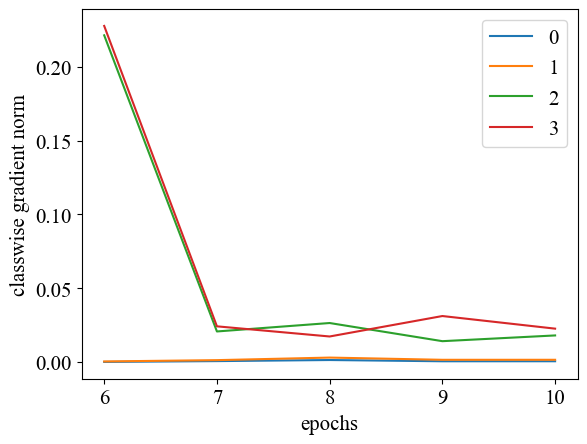

---------------------------- Task 3 -----------------------
Elapsed time(grad):16.984
losses=tensor([[2.2012e-03, 9.7284e-03, 6.4949e-02, 5.4965e-02, 9.4126e+00, 1.1568e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.432
Fairness:[ 0.47285819  0.47667099  0.28464383  0.         -0.4096319  -0.82454123]
Current class expected loss:[0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=10688
[11] Eval metrics for task 1 >> {'accuracy': 0.9490065629776139, 'loss': 0.0007811340245794743, 'std': 0.018394318079654803, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8468963466114053, 'loss': 0.0020914482031232813, 'std': 0.01646999002225802, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9536340222662636, 'loss': 0.0006536565872114012, 'std': 0.03210935858913355, 'EER': -1}
Elapsed time(grad):12.937
losses=tensor([[0.0034, 0.0025, 0.0031, 0.0103, 0.0922, 0.2366]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.73

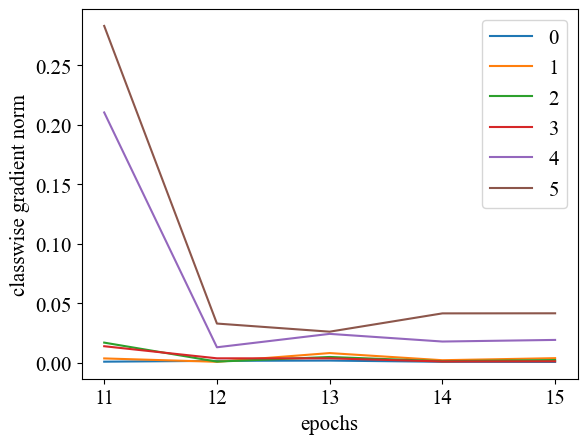

---------------------------- Task 4 -----------------------
Elapsed time(grad):11.227
losses=tensor([[1.3468e-03, 6.2522e-03, 5.9710e-03, 2.3026e-03, 6.4480e-02, 3.3471e-01,
         1.1913e+01, 1.0250e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):16.284
Fairness:[ 0.2293244   0.31417765  0.30473941  0.25241071 -0.13928113  0.
 -0.61461509 -0.3467563 ]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=11968
[16] Eval metrics for task 1 >> {'accuracy': 0.943023464892565, 'loss': 0.0009807428569658428, 'std': 0.022615301627258833, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.826989792002456, 'loss': 0.003174890675577431, 'std': 0.032416148591603355, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8972388645849506, 'loss': 0.001466416450676567, 'std': 0.05082630853113901, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9555636337051088, 'loss': 0.0006125928329497065, 'std': 0.003580335166486

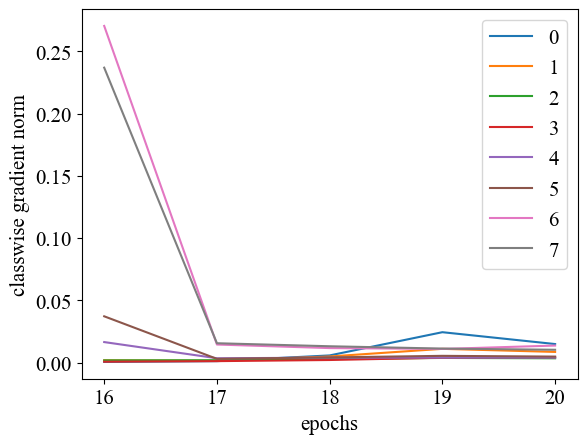

---------------------------- Task 5 -----------------------
Elapsed time(grad):11.417
losses=tensor([[1.2218e-02, 1.4262e-02, 8.9732e-03, 1.0014e-02, 1.3041e-02, 1.3189e-02,
         6.5940e-02, 3.9218e-03, 1.1977e+01, 1.3072e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):20.105
Fairness:[ 0.18472268  0.23851382  0.20664277  0.23067975  0.1584245   0.15262571
  0.14244594  0.         -0.59634423 -0.71771111]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=10176
[21] Eval metrics for task 1 >> {'accuracy': 0.9244965387035872, 'loss': 0.0011382907488103737, 'std': 0.017353681560730028, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7698912042367028, 'loss': 0.0041449528249540716, 'std': 0.005356320515772506, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.8114708246189254, 'loss': 0.0029072975908806635, 'std': 0.02559638515704199, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.8701290

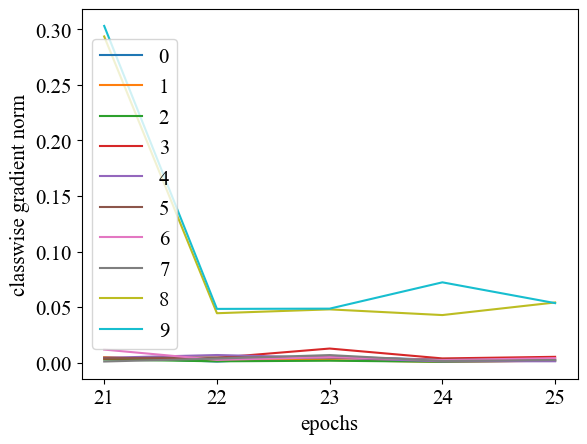

final avg-acc 0.8454767436152213
final avg-forget 0.1329615797691726


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.96 , 0.963, 0.   , 0.   , 0.   ],
       [0.946, 0.839, 0.937, 0.   , 0.   ],
       [0.909, 0.795, 0.903, 0.961, 0.   ],
       [0.902, 0.742, 0.833, 0.851, 0.899]])

In [7]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9210754005266211

In [8]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.001, 0.046, 0.048, 0.047]

In [9]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.02841978919084919

In [10]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.013, 0.069, 0.067, 0.067]

In [11]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.04354996167699377

In [12]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9210754005266211
EER:0.02841978919084919
std:0.04354996167699377
